In [29]:
import numpy as np
from keras.datasets import mnist
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Flatten, Input, Activation, AveragePooling2D
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Residual Networks
Residual networks, or ResNets are a neural network architecture that was designed to allow for deeper networks. It has been shown that there are functions that require an exponential number of hidden units to represent in a shallow neural network, but only require a polynomial number in deeper ones. The problem that comes with deeper networks is that as gradients flow back to earlier layers, they lose information. This is why older models such as AlexNet are not very deep: a deeper network would not be able to effectively learn.

ResNets alleviate this problem by introducing what are called "Residual", or "skip" connections. This corresponds to a structure that basically adds the input of a layer to its ouptut. This allows for gradient flow through the skip connections with less obfuscation from other layers, so deeper networks can still learn effectively. They also incorporate Batch Normalization, which is a technique that normalizes outputs to have zero mean and unit variance after a layer, which helps to regularize and keep training of these networks stable. ResNets have been successfully trained with up to 1000 layers, which demonstrates that they do not suffer from the same information loss problems as other types of network.

I decided to implement a ResNet to try to classify MNIST, but also as a challenge to minimize the number of parameters used. This model uses about 17000 parameters, which is a little more than twice the number of logistic regression, but achieves comparable or better performance to the basic CNN I implemented before (with many fewer parameters). I imitated the network structure from the original paper presenting ResNets (although some of their advice is now considered moderately out of data/illogical/incorrect), but I only have residual blocks at one size as an attempt to minimize parameter count and computational cost. I create ten residual blocks that use 8 convolutions with kernel size 3. This gives a structure conv$\to$BatchNorm$\to$ReLU$\to$conv$\to$BatchNorm within each residual block, and then the output is added to the input, and passed through a ReLU. Researchers at Facebook have investigated the order of the ReLU and BatchNorm, and found that this ordering seems to be optimal with this architecture. This model can also be made more efficient (in terms of parameter counts) by using 1x1 convolutions and max-pooling instead of a fully connected last layer. It is interesting to see that we can learn quite well with this small model. An interesting future task would be to see how small of a neural network could achieve 99 percent test accuracy on MNIST.

In [11]:
(x_train, y_train_orig), (x_test, y_test_orig) = mnist.load_data()
x_train = x_train[..., None] / 255.0
x_test = x_test[..., None] / 255.0
y_train = keras.utils.to_categorical(y_train_orig)
y_test = keras.utils.to_categorical(y_test_orig)

In [30]:
np.random.seed(1337)
reg = None

input_tensor = Input((28, 28, 1))
h = input_tensor
h = Conv2D(32, (3,3), padding='same', kernel_regularizer=reg)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

h = Conv2D(8, (3,3), strides=(2,2), padding='same', kernel_regularizer=reg)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)

for i in range(10):
    prev = h
    h = Conv2D(8, (3,3), padding='same', kernel_regularizer=reg)(h)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)
    h = Conv2D(8, (3,3), padding='same', kernel_regularizer=reg)(h)
    h = BatchNormalization()(h)
    h = keras.layers.Add()([h, prev])
    h = Activation('relu')(h)

h = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_regularizer=reg)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Conv2D(10, (1,1), kernel_regularizer=reg)(h)
h = BatchNormalization()(h)
h = Activation('relu')(h)
h = AveragePooling2D((7,7))(h)
h = Flatten()(h)

h = Activation('softmax')(h)
model = keras.Model(input_tensor, h)
model.compile(keras.optimizers.Adam(), keras.losses.categorical_crossentropy,
             metrics=['accuracy', ])

In [31]:
print('%d learnable parameters'%model.count_params())

17946 learnable parameters


In [ ]:
np.random.seed(1337)
model.fit(x_train, y_train, validation_split=0.15, epochs=12, batch_size=256) # gets about 99% test accuracy

In [36]:
# model = keras.models.load_model('./deep_resnet_mnist_pool.h5')
model.load_weights('./deep_resnet_mnist_pool.h5')

In [37]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 11s 1ms/step


[0.020728559610946103, 0.9938]

In [9]:
plot_model(model, )

In [38]:
pred_y = model.predict(x_test)

Text(0.5,1,'Confusion Matrix')

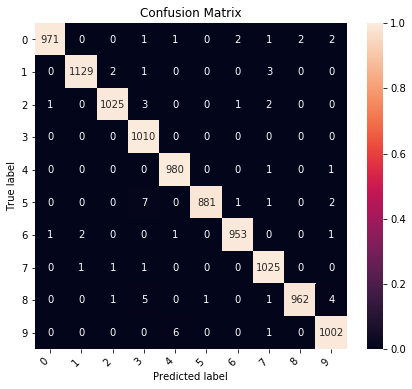

In [41]:
conf_mat = metrics.confusion_matrix(y_test_orig, pred_y.argmax(1))
class_names = list(range(10))
cm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(
    cm, index=class_names, columns=class_names, 
)
fig = plt.figure(figsize=(7, 6))
heatmap = sns.heatmap(df_cm, annot=conf_mat, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')